In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from torchsummary import summary

import copy

import torchvision

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
data = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)

In [3]:
print(data.classes)

print(str(len(data.classes)) + " classes")

print(data.data.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes
torch.Size([124800, 28, 28])


In [4]:
images = data.data.view([data.data.shape[0], 1, 28, 28]).float()
images.shape

torch.Size([124800, 1, 28, 28])

In [5]:
print(torch.sum(data.targets == 0))

print(torch.unique(data.targets))

tensor(0)
tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])


In [6]:
data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
letter_categories = data.classes[1:]

labels = copy.deepcopy(data.targets) - 1
print(labels.shape)

print(torch.sum(labels == 0))
print(torch.unique(labels))

torch.Size([124800])
tensor(4800)
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


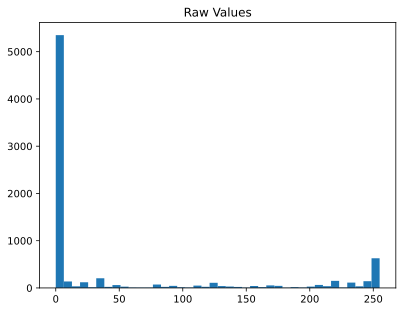

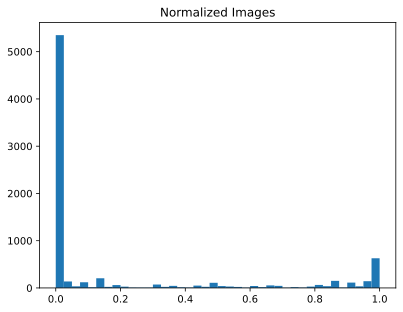

In [8]:
plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Raw Values")
plt.show()

images = images / torch.max(images)

plt.hist(images[:10, :, :, :].view(1, -1).detach(), 40)
plt.title("Normalized Images");

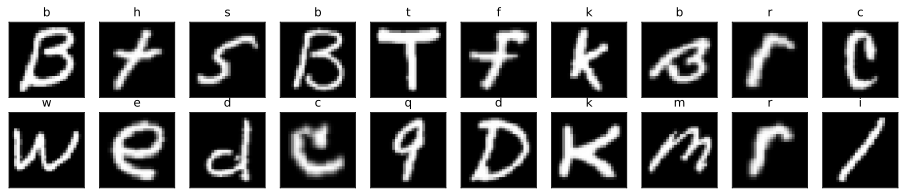

In [9]:
_, axis = plt.subplots(2, 10, figsize=(16, 3))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(images.shape[0])
    
    img = np.squeeze(images[pic, :, :])
    letter = letter_categories[labels[pic]]
    
    ax.imshow(img.T, cmap="gray")
    ax.set_title(f"{letter}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [10]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.2, random_state=17)

train_data = TensorDataset(train_data, train_label)
test_data = TensorDataset(test_data, test_label)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [11]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            self.b_norm1 = nn.BatchNorm2d(6)
            
            self.conv2 = nn.Conv2d(6, 6, 3, padding=1)
            self.b_norm2 = nn.BatchNorm2d(6)
            
            self.fc1 = nn.Linear(7*7*6, 50)
            
            self.out = nn.Linear(50, 26)
            
        def forward(self, x):
            
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm1(x)
            x = f.leaky_relu(x)
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm2(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            
            return self.out(x)
    
    cnn = CNN()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    
    return cnn, loss_fun, optimizer

In [12]:
summary(model()[0].to(device="cuda:0"), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
       BatchNorm2d-2            [-1, 6, 14, 14]              12
            Conv2d-3            [-1, 6, 14, 14]             330
       BatchNorm2d-4              [-1, 6, 7, 7]              12
            Linear-5                   [-1, 50]          14,750
            Linear-6                   [-1, 26]           1,326
Total params: 16,490
Trainable params: 16,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.06
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [13]:
def train_model():
    
    num_epochs = 10

    cnn, loss_fun, optimizer = model()
    
    cnn.to(device=device)
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            y_hat = cnn(x)
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_hat = y_hat.cpu()
            y = y.cpu()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
            
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        x, y = next(iter(test_loader))
        x = x.to(device)
        y = y.to(device)
        
        with torch.no_grad():
            y_hat = cnn(x)
            loss = loss_fun(y_hat, y)

        y_hat = y_hat.cpu()
        y = y.cpu()
        
        test_loss.append(loss.item())
        test_acc.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y).float()))
    
    return train_acc, test_acc, train_loss, test_loss, cnn

In [14]:
train_acc, test_acc, train_loss, test_loss, cnn = train_model()

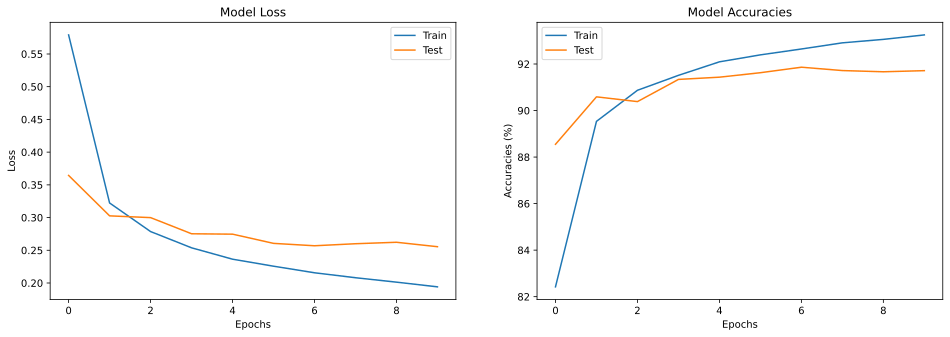

In [15]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_loss, "-", label="Train")
axis[0].plot(test_loss, "-", label="Test")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].set_title("Model Loss")
axis[0].legend()

axis[1].plot(train_acc, "-", label="Train")
axis[1].plot(test_acc, "-", label="Test")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_title("Model Accuracies")
axis[1].legend();

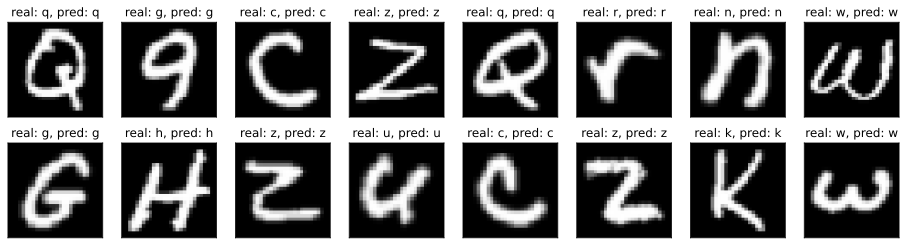

In [16]:
x, y = next(iter(test_loader))
cnn.to(device="cpu")
y_hat = cnn(x)

_, axis = plt.subplots(2, 8, figsize=(16, 4))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(x.shape[0])

    img = np.squeeze(x[pic, :, :])
    predict_letter = letter_categories[torch.argmax(y_hat[pic])]
    real_letter = letter_categories[y[pic]]
    
    ax.imshow(img.T, cmap="gray" if predict_letter == real_letter else "hot")
    ax.set_title(f"real: {real_letter}, pred: {predict_letter}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

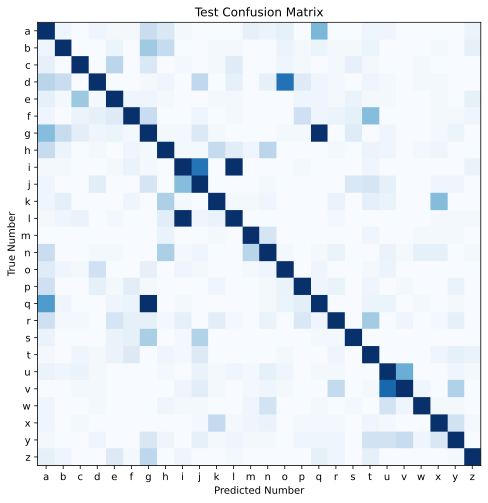

In [17]:
import sklearn.metrics as metrics

confusion = metrics.confusion_matrix(y, torch.argmax(y_hat, axis=1), normalize="true")

plt.figure(figsize=(8, 8))
plt.imshow(confusion, "Blues", vmax=0.05)

plt.xticks(range(26), labels=letter_categories)
plt.yticks(range(26), labels=letter_categories)
plt.title("Test Confusion Matrix")
plt.xlabel("True Number")
plt.xlabel("Predicted Number")
plt.ylabel("True Number");